In [1]:
from sqlalchemy import create_engine
import pandas as pd
import pymorphy2
from nltk import word_tokenize, ngrams
from tqdm.notebook import tqdm
import artm
from matplotlib import pyplot as plt
%matplotlib inline
import re
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
from multiprocessing.dummy import Pool as ThreadPool
import pickle

import warnings
warnings.filterwarnings("ignore")

D:\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

def remove_stopwords(text, check_status=True):
    stop_list = stopwords.words('russian')
    stop_list_2 = ["c","а","алло","без","белый","близко","более","больше","большой","будем","будет","будете","будешь","будто","буду","будут","будь","бы","бывает","бывь","был","была","были","было","быть","в","важная","важное","важные","важный","вам","вами","вас","ваш","ваша","ваше","ваши","вверх","вдали","вдруг","ведь","везде","вернуться","весь","вечер","взгляд","взять","вид","видел","видеть","вместе","вне","вниз","внизу","во","вода","война","вокруг","вон","вообще","вопрос","восемнадцатый","восемнадцать","восемь","восьмой","вот","впрочем","времени","время","все","все еще","всегда","всего","всем","всеми","всему","всех","всею","всю","всюду","вся","всё","второй","вы","выйти","г","где","главный","глаз","говорил","говорит","говорить","год","года","году","голова","голос","город","да","давать","давно","даже","далекий","далеко","дальше","даром","дать","два","двадцатый","двадцать","две","двенадцатый","двенадцать","дверь","двух","девятнадцатый","девятнадцать","девятый","девять","действительно","дел","делал","делать","делаю","дело","день","деньги","десятый","десять","для","до","довольно","долго","должен","должно","должный","дом","дорога","друг","другая","другие","других","друго","другое","другой","думать","душа","е","его","ее","ей","ему","если","есть","еще","ещё","ею","её","ж","ждать","же","жена","женщина","жизнь","жить","за","занят","занята","занято","заняты","затем","зато","зачем","здесь","земля","знать","значит","значить","и","иди","идти","из","или","им","имеет","имел","именно","иметь","ими","имя","иногда","их","к","каждая","каждое","каждые","каждый","кажется","казаться","как","какая","какой","кем","книга","когда","кого","ком","комната","кому","конец","конечно","которая","которого","которой","которые","который","которых","кроме","кругом","кто","куда","лежать","лет","ли","лицо","лишь","лучше","любить","люди","м","маленький","мало","мать","машина","между","меля","менее","меньше","меня","место","миллионов","мимо","минута","мир","мира","мне","много","многочисленная","многочисленное","многочисленные","многочисленный","мной","мною","мог","могу","могут","мож","может","может быть","можно","можхо","мои","мой","мор","москва","мочь","моя","моё","мы","на","наверху","над","надо","назад","наиболее","найти","наконец","нам","нами","народ","нас","начала","начать","наш","наша","наше","наши","не","него","недавно","недалеко","нее","ней","некоторый","нельзя","нем","немного","нему","непрерывно","нередко","несколько","нет","нею","неё","ни","нибудь","ниже","низко","никакой","никогда","никто","никуда","ним","ними","них","ничего","ничто","но","новый","нога","ночь","ну","нужно","нужный","нх","о","об","оба","обычно","один","одиннадцатый","одиннадцать","однажды","однако","одного","одной","оказаться","окно","около","он","она","они","оно","опять","особенно","остаться","от","ответить","отец","откуда","отовсюду","отсюда","очень","первый","перед","писать","плечо","по","под","подойди","подумать","пожалуйста","позже","пойти","пока","пол","получить","помнить","понимать","понять","пор","пора","после","последний","посмотреть","посреди","потом","потому","почему","почти","правда","прекрасно","при","про","просто","против","процентов","путь","пятнадцатый","пятнадцать","пятый","пять","работа","работать","раз","разве","рано","раньше","ребенок","решить","россия","рука","русский","ряд","рядом","с","с кем","сам","сама","сами","самим","самими","самих","само","самого","самой","самом","самому","саму","самый","свет","свое","своего","своей","свои","своих","свой","свою","сделать","сеаой","себе","себя","сегодня","седьмой","сейчас","семнадцатый","семнадцать","семь","сидеть","сила","сих","сказал","сказала","сказать","сколько","слишком","слово","случай","смотреть","сначала","снова","со","собой","собою","советский","совсем","спасибо","спросить","сразу","стал","старый","стать","стол","сторона","стоять","страна","суть","считать","т","та","так","такая","также","таки","такие","такое","такой","там","твои","твой","твоя","твоё","те","тебе","тебя","тем","теми","теперь","тех","то","тобой","тобою","товарищ","тогда","того","тоже","только","том","тому","тот","тою","третий","три","тринадцатый","тринадцать","ту","туда","тут","ты","тысяч","у","увидеть","уж","уже","улица","уметь","утро","хороший","хорошо","хотел бы","хотеть","хоть","хотя","хочешь","час","часто","часть","чаще","чего","человек","чем","чему","через","четвертый","четыре","четырнадцатый","четырнадцать","что","чтоб","чтобы","чуть","шестнадцатый","шестнадцать","шестой","шесть","эта","эти","этим","этими","этих","это","этого","этой","этом","этому","этот","эту","я","являюсь"]
    with open('RussianStopWords.txt', encoding='utf-8') as stops:
        heh = stops.read()
        stop_list_3 = heh.split('\n')
    stops.close()
    set_stop = set(stop_list)
    set_stop.update(stop_list_2)
    set_stop.update(stop_list_3)
    # тут еще мои добавочки, слова связанные с регионами ниже убираю
    set_stop.update(['россия', 'российский', 'рубль', 'нажать', 'ошибка', 'выделить', 'текст', 'наслать', 'версия', 'пожалуйста', 
                     'интересно', 'фрагмент', 'мочь', 'свой', 'весь', 'очень', 'подписаться', 'яндекс', 'дзен', 'новость', 'новости',
                     'гугл', 'январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь',
                     'ноябрь', 'декабрь', 'область', 'район', 'регион', 'глава', 'региональный', 'летний', 'зимний', 'осенний',
                     'зимний', 'тысяча', 'миллион', 'миллиард', 'триллион', 'президент', 'премьер-министр', 'губернатор',
                     'город', 'зима', 'весна', 'лето', 'осень', 'число', 'поэтому', 'нижний', 'новгород', 'фото', 'рассказать',
                     'сообщить', 'неделя', 'сутки', 'месяц', 'год', 'результат', 'млрд', 'млн', 'трлн', 'руб', 'нижний',
                     'новгород', 'поделиться', 'например', 'многие', 'ранее', 'акция', 'сотрудник'])
    locs = pd.read_csv('locs.csv', header=None)
    city_list = list(locs[2])
    for i in range(len(city_list)):
        city_list[i] = city_list[i].replace('ж/д ', '').replace('с ', '').replace('п ', '').replace('рзд ', '').replace('ст ', '')
        city_list[i] = city_list[i].lower()
    set_stop.update(city_list)
    prilag_stops = ['удмурт', 'нижегород', 'татар', 'мордв', 'марий', 'самар', 'киров', 'сарат', 'пенз', 'чуваш', 'ульян']
    
    morph = pymorphy2.MorphAnalyzer()
    words = []
    if check_status:
        txt_news = tqdm(text)
    else:
        txt_news = text
    for news_proc in txt_news:
        news_proc = word_tokenize(news_proc[0])
        words_lem = []
        for word in news_proc:
            p = morph.parse(word)
            lem = word
            #убираем мусор из стоп-листа и имена с фамилиями
            if word not in set_stop and not ('Surn' in p[0].tag or 'Name' in p[0].tag) and len(lem) > 3:
                if not any(prilag in lem for prilag in prilag_stops):
                    words_lem.append(lem)
        words.append(words_lem)
    return words

def make_bigrams(texts, save=False):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=50)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    if save:
        bigram.save('model/grams/bigrams.phs')
        try:
            bigram.save('model/grams/bigrams.pkl')
        except:
            pass
    print('создаем биграммы')
    return [bigram_mod[doc] for doc in tqdm(texts)]

def make_trigrams(texts, save=False):
    trigram = gensim.models.Phrases(texts, min_count=5, threshold=50)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    if save:
        trigram.save('model/grams/trigrams.phs')
        try:
            trigram.save('model/grams/trigrams.pkl')
        except:
            pass
    print('создаем триграммы')
    return [trigram_mod[doc] for doc in tqdm(texts)]

In [45]:
import csv

In [ ]:
bigram = gensim.models.Phrases(text, min_count=5, threshold=50)

In [ ]:
bigram.save('model/grams/bigrams.phs')

In [47]:
with open('model/text_ready_full/text_full.txt', 'w') as tx:
    writer = csv.writer(tx)
    writer.writerows(text)
    tx.close()

In [52]:
text_text = make_bigrams(text, save=True)
text_text = make_trigrams(text_text, save=True)

MemoryError: 

In [5]:
engine = create_engine('sqlite:///D:/Work/Pycharm_projects/Text_analysis/news_base.db', echo=False)
sqlite_connection = engine.connect()
text = sqlite_connection.execute("SELECT stemmed FROM news_db").fetchall()

TypeError: expected string or bytes-like object

In [20]:
text = remove_stopwords(text)

In [21]:
print('биграммы')
text_grams = make_bigrams(text, save=True)
text_grams = make_trigrams(text_grams, save=True)
id2word = corpora.Dictionary(text_grams)

id2word.filter_extremes(no_below=20, no_above=0.7)

corpus = [id2word.doc2bow(txt) for txt in text_grams]
print('сохранение')
pickle.dump(corpus, open('model/corpus_full.pkl', 'wb'))
id2word.save('model/dictionary_full.gensim')
print('модель')

биграммы
создаем биграммы



создаем триграммы



сохранение
модель


In [22]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=13,
                         chunksize=1000,
                         passes=5,
                         random_state=100,
                         alpha='symmetric',
                         per_word_topics=True,
                         decay=0.5)
for num, params in lda_model.print_topics():
    print(f'{num}: {params}\n')
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_grams, dictionary=id2word, coherence='c_v')
coherence_model_lda.get_coherence()

0: 0.044*"водитель" + 0.036*"автомобиль" + 0.024*"произойти" + 0.022*"пострадать" + 0.016*"мужчина" + 0.014*"авария" + 0.012*"происшествие" + 0.011*"гибдд" + 0.010*"погибнуть" + 0.010*"травма"

1: 0.031*"команда" + 0.019*"матч" + 0.013*"спорт" + 0.013*"клуб" + 0.009*"сезон" + 0.009*"спортивный" + 0.008*"тренер" + 0.008*"игрок" + 0.008*"спортсмен" + 0.008*"чемпионат"

2: 0.005*"проблема" + 0.004*"ребёнок" + 0.004*"стоить" + 0.003*"помочь" + 0.003*"любой" + 0.003*"животное" + 0.003*"использовать" + 0.002*"разный" + 0.002*"семья" + 0.002*"больший"

3: 0.015*"объект" + 0.013*"проект" + 0.012*"строительство" + 0.012*"территория" + 0.010*"коронавирусный_инфекция" + 0.009*"городской" + 0.008*"администрация" + 0.006*"ремонт" + 0.006*"отметить" + 0.006*"участок"

4: 0.019*"житель" + 0.012*"квартира" + 0.008*"сообщать" + 0.006*"здание" + 0.006*"пожарный" + 0.006*"градус" + 0.006*"пресс_служба" + 0.005*"произойти" + 0.005*"ночью" + 0.005*"жилой"

5: 0.021*"ребёнок" + 0.019*"школа" + 0.016*"проект

0.5633891365324437

In [23]:
lda_model.save('model/model_full.gensim')

ERROR! Session/line number was not unique in database. History logging moved to new session 54



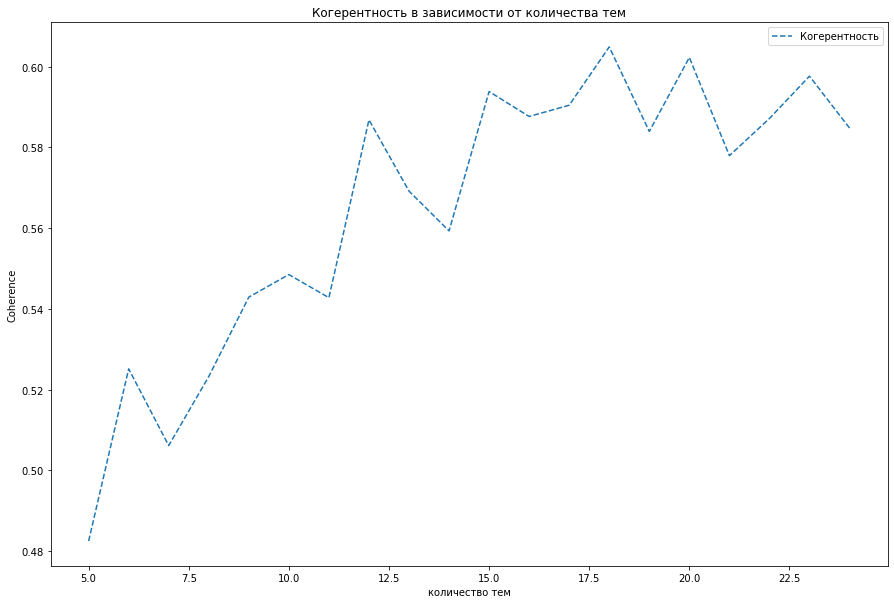

In [24]:
coh_score = []
for i in tqdm(range(5, 25)):
    lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=i,
                         chunksize=1000,
                         passes=5,
                         random_state=100,
                         alpha='symmetric',
                         per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=text_grams, dictionary=id2word, coherence='c_v')
    coh_score.append(coherence_model_lda.get_coherence())
fig = plt.figure(figsize = [15,10])
ax_1 = fig.add_subplot(1, 1, 1)
ax_1.set_title('Когерентность в зависимости от количества тем')
ax_1.set_xlabel('количество тем')
ax_1.set_ylabel('Coherence')
ax_1.plot(range(5, 25), coh_score, linestyle='dashed', label = 'Когерентность')
ax_1.legend()
fig.show()

In [27]:
for i in range(len(coh_score)):
    print(i+4, round(coh_score[i],2))

4 0.48
5 0.53
6 0.51
7 0.52
8 0.54
9 0.55
10 0.54
11 0.59
12 0.57
13 0.56
14 0.59
15 0.59
16 0.59
17 0.6
18 0.58
19 0.6
20 0.58
21 0.59
22 0.6
23 0.58


In [3]:
corpus = pickle.load(open('model/corpus_full.pkl', 'rb'))
id2word = corpora.Dictionary.load(f'model/dictionary_full.gensim')
with open('model/text_ready_full/text_full.txt', 'r', encoding='utf-8') as text_train:
    text_train = text_train.readlines()

In [8]:
text_grams = [line.split(',') for line in tqdm(text_train) if line != '\n']

In [ ]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=11,
                         chunksize=1000,
                         passes=20,
                         random_state=100,
                         alpha='symmetric',
                         per_word_topics=True,
                         decay=0.5)
for num, params in lda_model.print_topics():
    print(f'{num}: {params}\n')
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_grams, dictionary=id2word, coherence='c_v')
coherence_model_lda.get_coherence()

In [28]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=11,
                         chunksize=1000,
                         passes=5,
                         random_state=100,
                         alpha='symmetric',
                         per_word_topics=True,
                         decay=0.5)
for num, params in lda_model.print_topics():
    print(f'{num}: {params}\n')
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_grams, dictionary=id2word, coherence='c_v')
coherence_model_lda.get_coherence()
lda_model.save('model/model_full_11.gensim')

0: 0.042*"водитель" + 0.032*"автомобиль" + 0.018*"движение" + 0.016*"произойти" + 0.014*"авария" + 0.014*"пострадать" + 0.014*"транспорт" + 0.013*"пассажир" + 0.011*"маршрут" + 0.010*"гибдд"

1: 0.013*"мужчина" + 0.011*"полиция" + 0.010*"прокуратура" + 0.010*"задержать" + 0.009*"отношение" + 0.009*"житель" + 0.008*"нарушение" + 0.007*"сообщать" + 0.007*"проверка" + 0.007*"полицейский"

2: 0.005*"проблема" + 0.004*"стоить" + 0.003*"ребёнок" + 0.003*"любой" + 0.003*"помочь" + 0.003*"разный" + 0.002*"больший" + 0.002*"ситуация" + 0.002*"использовать" + 0.002*"специалист"

3: 0.014*"объект" + 0.013*"проект" + 0.012*"строительство" + 0.011*"территория" + 0.011*"администрация" + 0.010*"житель" + 0.009*"городской" + 0.008*"участок" + 0.008*"ремонт" + 0.006*"здание"

4: 0.021*"мужчина" + 0.013*"ребёнок" + 0.013*"произойти" + 0.011*"житель" + 0.011*"квартира" + 0.009*"пострадать" + 0.009*"сообщать" + 0.007*"происшествие" + 0.006*"тело" + 0.006*"информация"

5: 0.022*"ребёнок" + 0.019*"школа" + 

In [29]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=12,
                         chunksize=1000,
                         passes=5,
                         random_state=100,
                         alpha='symmetric',
                         per_word_topics=True,
                         decay=0.5)
for num, params in lda_model.print_topics():
    print(f'{num}: {params}\n')
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_grams, dictionary=id2word, coherence='c_v')
coherence_model_lda.get_coherence()
lda_model.save('model/model_full_12.gensim')

0: 0.041*"водитель" + 0.032*"автомобиль" + 0.018*"произойти" + 0.017*"движение" + 0.017*"пострадать" + 0.013*"авария" + 0.012*"транспорт" + 0.011*"пассажир" + 0.010*"мужчина" + 0.010*"гибдд"

1: 0.030*"команда" + 0.020*"матч" + 0.018*"спорт" + 0.014*"клуб" + 0.014*"спортивный" + 0.011*"сезон" + 0.009*"тренер" + 0.009*"игрок" + 0.008*"спортсмен" + 0.008*"чемпионат"

2: 0.005*"ребёнок" + 0.004*"проблема" + 0.004*"стоить" + 0.003*"любой" + 0.003*"помочь" + 0.003*"разный" + 0.002*"использовать" + 0.002*"больший" + 0.002*"специалист" + 0.002*"магазин"

3: 0.014*"объект" + 0.013*"проект" + 0.011*"строительство" + 0.011*"территория" + 0.010*"администрация" + 0.008*"городской" + 0.007*"житель" + 0.007*"ремонт" + 0.007*"участок" + 0.006*"предприятие"

4: 0.016*"житель" + 0.012*"квартира" + 0.010*"произойти" + 0.009*"сообщать" + 0.007*"пострадать" + 0.007*"градус" + 0.007*"пожарный" + 0.007*"причина" + 0.006*"пресс_служба" + 0.006*"ночью"

5: 0.021*"ребёнок" + 0.018*"школа" + 0.015*"проект" + 0.

In [30]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=14,
                         chunksize=1000,
                         passes=5,
                         random_state=100,
                         alpha='symmetric',
                         per_word_topics=True,
                         decay=0.5)
for num, params in lda_model.print_topics():
    print(f'{num}: {params}\n')
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_grams, dictionary=id2word, coherence='c_v')
coherence_model_lda.get_coherence()
lda_model.save('model/model_full_14.gensim')

0: 0.050*"водитель" + 0.039*"автомобиль" + 0.022*"произойти" + 0.021*"пострадать" + 0.016*"авария" + 0.013*"мужчина" + 0.012*"гибдд" + 0.011*"травма" + 0.011*"движение" + 0.010*"происшествие"

1: 0.034*"команда" + 0.022*"матч" + 0.015*"клуб" + 0.012*"сезон" + 0.011*"спорт" + 0.010*"игрок" + 0.010*"тренер" + 0.009*"чемпионат" + 0.008*"счёт" + 0.008*"спортсмен"

2: 0.004*"проблема" + 0.004*"стоить" + 0.003*"ребёнок" + 0.003*"любой" + 0.003*"разный" + 0.002*"помочь" + 0.002*"больший" + 0.002*"использовать" + 0.002*"заниматься" + 0.002*"учёный"

3: 0.014*"объект" + 0.013*"проект" + 0.012*"строительство" + 0.011*"территория" + 0.009*"администрация" + 0.009*"городской" + 0.008*"житель" + 0.008*"ремонт" + 0.008*"участок" + 0.006*"здание"

4: 0.015*"квартира" + 0.012*"житель" + 0.012*"произойти" + 0.011*"сообщать" + 0.009*"пожарный" + 0.008*"градус" + 0.008*"пострадать" + 0.008*"мужчина" + 0.008*"пресс_служба" + 0.008*"причина"

5: 0.017*"ребёнок" + 0.016*"школа" + 0.015*"проект" + 0.011*"разв

In [31]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=15,
                         chunksize=1000,
                         passes=5,
                         random_state=100,
                         alpha='symmetric',
                         per_word_topics=True,
                         decay=0.5)
for num, params in lda_model.print_topics():
    print(f'{num}: {params}\n')
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_grams, dictionary=id2word, coherence='c_v')
coherence_model_lda.get_coherence()
lda_model.save('model/model_full_15.gensim')

0: 0.043*"водитель" + 0.033*"автомобиль" + 0.017*"произойти" + 0.017*"движение" + 0.015*"пострадать" + 0.014*"пассажир" + 0.014*"авария" + 0.013*"транспорт" + 0.011*"маршрут" + 0.010*"гибдд"

1: 0.028*"республика" + 0.024*"конкурс" + 0.020*"участник" + 0.015*"пройти" + 0.014*"мероприятие" + 0.012*"участие" + 0.011*"мордовия" + 0.010*"управление" + 0.010*"принять_участие" + 0.009*"проведение"

2: 0.008*"компания" + 0.007*"магазин" + 0.007*"продукт" + 0.007*"цена" + 0.006*"товар" + 0.006*"продукция" + 0.005*"производство" + 0.005*"использовать" + 0.004*"торговый" + 0.004*"сеть"

3: 0.015*"объект" + 0.013*"строительство" + 0.013*"житель" + 0.012*"администрация" + 0.012*"территория" + 0.011*"проект" + 0.010*"городской" + 0.010*"участок" + 0.009*"ремонт" + 0.007*"здание"

4: 0.013*"произойти" + 0.010*"пострадать" + 0.010*"сообщать" + 0.009*"квартира" + 0.009*"градус" + 0.009*"пожарный" + 0.008*"ночью" + 0.008*"причина" + 0.008*"погибнуть" + 0.008*"житель"

5: 0.020*"проект" + 0.018*"школа" 

In [32]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=16,
                         chunksize=1000,
                         passes=5,
                         random_state=100,
                         alpha='symmetric',
                         per_word_topics=True,
                         decay=0.5)
for num, params in lda_model.print_topics():
    print(f'{num}: {params}\n')
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_grams, dictionary=id2word, coherence='c_v')
coherence_model_lda.get_coherence()
lda_model.save('model/model_full_16.gensim')

0: 0.048*"водитель" + 0.037*"автомобиль" + 0.022*"произойти" + 0.020*"пострадать" + 0.016*"движение" + 0.016*"авария" + 0.013*"мужчина" + 0.012*"гибдд" + 0.011*"травма" + 0.010*"происшествие"

1: 0.013*"военный" + 0.010*"ветеран" + 0.009*"история" + 0.009*"семья" + 0.009*"память" + 0.008*"праздник" + 0.006*"великий_отечественный" + 0.006*"герой" + 0.005*"памятник" + 0.005*"волонтёр"

2: 0.005*"ребёнок" + 0.005*"проблема" + 0.005*"стоить" + 0.003*"любой" + 0.003*"помочь" + 0.003*"разный" + 0.003*"магазин" + 0.003*"прийтись" + 0.002*"ситуация" + 0.002*"больший"

3: 0.016*"объект" + 0.014*"строительство" + 0.014*"проект" + 0.012*"территория" + 0.011*"житель" + 0.011*"администрация" + 0.010*"городской" + 0.010*"участок" + 0.009*"ремонт" + 0.007*"здание"

4: 0.012*"квартира" + 0.012*"произойти" + 0.011*"житель" + 0.010*"сообщать" + 0.009*"пожарный" + 0.009*"градус" + 0.008*"пострадать" + 0.008*"ночью" + 0.008*"причина" + 0.007*"происшествие"

5: 0.024*"ребёнок" + 0.021*"проект" + 0.021*"шко

In [33]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=19,
                         chunksize=1000,
                         passes=5,
                         random_state=100,
                         alpha='symmetric',
                         per_word_topics=True,
                         decay=0.5)
for num, params in lda_model.print_topics():
    print(f'{num}: {params}\n')
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_grams, dictionary=id2word, coherence='c_v')
coherence_model_lda.get_coherence()
lda_model.save('model/model_full_19.gensim')

0: 0.057*"водитель" + 0.044*"автомобиль" + 0.022*"произойти" + 0.021*"пострадать" + 0.018*"авария" + 0.013*"гибдд" + 0.013*"мужчина" + 0.012*"движение" + 0.012*"травма" + 0.010*"происшествие"

1: 0.061*"республика" + 0.024*"управление" + 0.023*"нарушение" + 0.022*"мордовия" + 0.017*"проверка" + 0.012*"территория" + 0.012*"провести" + 0.011*"выявить" + 0.011*"обязательный" + 0.011*"служба"

2: 0.013*"магазин" + 0.009*"товар" + 0.009*"продукт" + 0.008*"торговый" + 0.006*"продукция" + 0.006*"маска" + 0.006*"использовать" + 0.005*"покупатель" + 0.004*"материал" + 0.004*"стоить"

3: 0.023*"проект" + 0.015*"территория" + 0.013*"предприятие" + 0.011*"житель" + 0.011*"развитие" + 0.010*"городской" + 0.009*"отметить" + 0.008*"благоустройство" + 0.008*"реализация" + 0.007*"программа"

4: 0.017*"произойти" + 0.016*"житель" + 0.013*"мужчина" + 0.012*"квартира" + 0.012*"пострадать" + 0.010*"происшествие" + 0.010*"обнаружить" + 0.010*"сообщать" + 0.009*"причина" + 0.009*"погибнуть"

5: 0.031*"ребёно

In [34]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=17,
                         chunksize=1000,
                         passes=5,
                         random_state=100,
                         alpha='symmetric',
                         per_word_topics=True,
                         decay=0.5)
for num, params in lda_model.print_topics():
    print(f'{num}: {params}\n')
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_grams, dictionary=id2word, coherence='c_v')
coherence_model_lda.get_coherence()
lda_model.save('model/model_full_17.gensim')

0: 0.055*"водитель" + 0.043*"автомобиль" + 0.021*"произойти" + 0.019*"пострадать" + 0.017*"авария" + 0.013*"гибдд" + 0.013*"движение" + 0.011*"травма" + 0.011*"мужчина" + 0.010*"происшествие"

1: 0.057*"республика" + 0.023*"мордовия" + 0.013*"управление" + 0.012*"служба" + 0.012*"территория" + 0.010*"военный" + 0.010*"обязательный" + 0.010*"мордовмедиа_использование_материал_гиперссылка" + 0.009*"мероприятие" + 0.009*"йошкара"

2: 0.011*"цена" + 0.008*"магазин" + 0.008*"продукт" + 0.007*"товар" + 0.006*"использовать" + 0.005*"продукция" + 0.005*"продажа" + 0.005*"стоимость" + 0.005*"специалист" + 0.004*"компания"

3: 0.016*"проект" + 0.014*"развитие" + 0.012*"бизнес" + 0.010*"предприятие" + 0.010*"компания" + 0.009*"поддержка" + 0.008*"отметить" + 0.008*"программа" + 0.007*"бюджет" + 0.007*"уровень"

4: 0.025*"житель" + 0.015*"квартира" + 0.010*"администрация" + 0.007*"компания" + 0.007*"нарушение" + 0.007*"проверка" + 0.007*"прокуратура" + 0.006*"местный" + 0.006*"проблема" + 0.005*"у

In [35]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=19,
                         chunksize=1000,
                         passes=5,
                         random_state=100,
                         alpha='symmetric',
                         per_word_topics=True,
                         decay=0.5)
for num, params in lda_model.print_topics():
    print(f'{num}: {params}\n')
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_grams, dictionary=id2word, coherence='c_v')
coherence_model_lda.get_coherence()
lda_model.save('model/model_full_19.gensim')

0: 0.057*"водитель" + 0.044*"автомобиль" + 0.022*"произойти" + 0.019*"пострадать" + 0.019*"авария" + 0.014*"гибдд" + 0.013*"движение" + 0.012*"мужчина" + 0.011*"травма" + 0.010*"происшествие"

1: 0.106*"республика" + 0.033*"мордовия" + 0.019*"территория" + 0.015*"обязательный" + 0.014*"мордовмедиа_использование_материал_гиперссылка" + 0.012*"йошкара" + 0.011*"пресс_служба" + 0.011*"управление" + 0.010*"сообщать" + 0.009*"информ"

2: 0.009*"магазин" + 0.008*"продукт" + 0.008*"товар" + 0.006*"использовать" + 0.005*"специалист" + 0.004*"продукция" + 0.004*"качество" + 0.004*"материал" + 0.004*"стоить" + 0.004*"являться"

3: 0.016*"объект" + 0.015*"строительство" + 0.013*"проект" + 0.012*"житель" + 0.012*"территория" + 0.010*"администрация" + 0.010*"ремонт" + 0.010*"участок" + 0.010*"городской" + 0.007*"здание"

4: 0.021*"квартира" + 0.019*"произойти" + 0.016*"мужчина" + 0.015*"ребёнок" + 0.014*"пострадать" + 0.011*"происшествие" + 0.011*"обнаружить" + 0.010*"тело" + 0.010*"погибнуть" + 0.

In [36]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=21,
                         chunksize=1000,
                         passes=5,
                         random_state=100,
                         alpha='symmetric',
                         per_word_topics=True,
                         decay=0.5)
for num, params in lda_model.print_topics():
    print(f'{num}: {params}\n')
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_grams, dictionary=id2word, coherence='c_v')
coherence_model_lda.get_coherence()
lda_model.save('model/model_full_21.gensim')

3: 0.019*"проект" + 0.016*"развитие" + 0.015*"предприятие" + 0.011*"бизнес" + 0.010*"компания" + 0.009*"поддержка" + 0.008*"отметить" + 0.008*"производство" + 0.008*"правительство" + 0.007*"реализация"

10: 0.022*"музей" + 0.014*"пропасть" + 0.013*"волонтёр" + 0.011*"информация" + 0.011*"сообщать" + 0.010*"поиск" + 0.009*"самолёт" + 0.009*"турист" + 0.007*"выставка" + 0.007*"находиться"

19: 0.067*"коронавирус" + 0.025*"заболеть" + 0.021*"пациент" + 0.019*"выявить" + 0.014*"пандемия" + 0.014*"заболевание" + 0.013*"заражение" + 0.011*"подтвердить" + 0.011*"житель" + 0.011*"находиться"

18: 0.007*"ситуация" + 0.007*"проблема" + 0.005*"мнение" + 0.004*"эксперт" + 0.004*"специалист" + 0.004*"стоить" + 0.004*"учёный" + 0.004*"бизнес" + 0.003*"уровень" + 0.003*"являться"

0: 0.056*"водитель" + 0.043*"автомобиль" + 0.023*"произойти" + 0.021*"пострадать" + 0.017*"авария" + 0.013*"гибдд" + 0.013*"мужчина" + 0.012*"травма" + 0.011*"движение" + 0.010*"происшествие"

2: 0.012*"магазин" + 0.010*"то

In [37]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=22,
                         chunksize=1000,
                         passes=5,
                         random_state=100,
                         alpha='symmetric',
                         per_word_topics=True,
                         decay=0.5)
for num, params in lda_model.print_topics():
    print(f'{num}: {params}\n')
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_grams, dictionary=id2word, coherence='c_v')
coherence_model_lda.get_coherence()
lda_model.save('model/model_full_22.gensim')

16: 0.018*"военный" + 0.014*"градус" + 0.013*"ветеран" + 0.011*"память" + 0.010*"погода" + 0.010*"ожидаться" + 0.009*"великий_отечественный" + 0.009*"ночью" + 0.008*"житель" + 0.007*"пройти"

13: 0.019*"заместитель" + 0.019*"руководитель" + 0.016*"управление" + 0.013*"должность" + 0.013*"директор" + 0.012*"министр" + 0.011*"администрация" + 0.011*"начальник" + 0.011*"председатель" + 0.010*"государственный"

4: 0.019*"произойти" + 0.016*"квартира" + 0.015*"мужчина" + 0.014*"пострадать" + 0.012*"житель" + 0.012*"происшествие" + 0.011*"сообщать" + 0.010*"погибнуть" + 0.010*"пожарный" + 0.009*"причина"

19: 0.068*"коронавирус" + 0.026*"заболеть" + 0.020*"выявить" + 0.019*"пациент" + 0.014*"заболевание" + 0.014*"заражение" + 0.012*"житель" + 0.012*"подтвердить" + 0.011*"данные" + 0.011*"зарегистрировать"

0: 0.059*"водитель" + 0.045*"автомобиль" + 0.022*"произойти" + 0.020*"пострадать" + 0.018*"авария" + 0.014*"гибдд" + 0.013*"мужчина" + 0.012*"движение" + 0.012*"травма" + 0.010*"происшеств